In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import numpy as np
from transformers import AutoTokenizer, ModernBertForSequenceClassification
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import random
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm
import torch.nn as nn
from safetensors import safe_open
from safetensors.torch import load_file
from torch.utils.data import Dataset, DataLoader


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 设置随机种子以确保结果可复现
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

In [3]:

set_seed(3407)

In [4]:
# 加载数据集
dataset=load_dataset('json',data_files='/root/for_may_conference/remake/data_for_train_bert_need_shuffle.json')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'score'],
        num_rows: 78200
    })
})

In [5]:
# 数据集随机打乱
shuffled_dataset = dataset["train"].shuffle(seed=3407)

In [6]:
train_test_split = shuffled_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

In [9]:
# 保存eval_dataset
eval_dataset.save_to_disk('/root/for_may_conference/tele-chat_old/eval_dataset')
train_dataset.save_to_disk('/root/for_may_conference/tele-chat_old/train_dataset')

Saving the dataset (2/2 shards): 100%|██████████| 66861/66861 [00:01<00:00, 45335.15 examples/s]


In [7]:
train_test_split = train_dataset.train_test_split(test_size=0.05)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [8]:

# 1. 加载保存的模型和tokenizer
model_name="neavo/modern_bert_multilingual"
tokenizer = AutoTokenizer.from_pretrained("neavo/modern_bert_multilingual")


In [9]:
class CustomModel(nn.Module):
    def __init__(self, model_name="neavo/modern_bert_multilingual"):
        super().__init__()
        self.bert = ModernBertForSequenceClassification.from_pretrained(model_name, num_labels=18)
        self.regression_head = nn.Linear(18, 1)
        
        # 启用梯度检查点
        self.bert.gradient_checkpointing_enable()

    def forward(self, input_ids, attention_mask, labels=None, score=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        logits = outputs.logits
        regression_output = self.regression_head(logits)
        
        loss = None
        if labels is not None and score is not None:
            cls_loss = nn.CrossEntropyLoss()(logits, labels)
            reg_loss = nn.MSELoss()(regression_output, score.view(-1, 1))
            loss = 0.5 * cls_loss + 0.5 * reg_loss
        
        # 返回元组而不是字典，使其与Trainer兼容
        return (loss, logits, regression_output) if loss is not None else (logits, regression_output)

In [10]:
model = CustomModel(model_name=model_name)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at neavo/modern_bert_multilingual and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model

CustomModel(
  (bert): ModernBertForSequenceClassification(
    (model): ModernBertModel(
      (embeddings): ModernBertEmbeddings(
        (tok_embeddings): Embedding(151680, 768, padding_idx=151646)
        (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (layers): ModuleList(
        (0): ModernBertEncoderLayer(
          (attn_norm): Identity()
          (attn): ModernBertAttention(
            (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
            (rotary_emb): ModernBertUnpaddedRotaryEmbedding(dim=64, base=160000.0, scale_base=None)
            (Wo): Linear(in_features=768, out_features=768, bias=False)
            (out_drop): Identity()
          )
          (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): ModernBertMLP(
            (Wi): Linear(in_features=768, out_features=2304, bias=False)
            (act): GELUActivation()
            (drop): Dropou

In [12]:
# 如果有GPU可用，将模型移至GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model_path = "/root/for_may_conference/remake/train_other_bert/checkpoints/checkpoint-8358/model.safetensors"


In [14]:
state_dict = load_file(model_path)
state_dict

{'bert.classifier.bias': tensor([ 7.6123e-04,  4.0070e-04, -7.2776e-05, -6.6291e-05, -2.4896e-04,
         -2.5795e-04, -7.2031e-04, -6.6558e-04, -4.4198e-04, -1.2196e-03,
         -2.1009e-03, -3.1768e-04, -7.1901e-04, -7.8022e-04,  3.7028e-04,
          5.0100e-04,  3.3269e-04, -3.0929e-04]),
 'bert.classifier.weight': tensor([[ 0.0251,  0.0208, -0.0306,  ...,  0.0279, -0.0176,  0.0007],
         [ 0.0215, -0.0561, -0.0538,  ..., -0.0614, -0.0421, -0.0103],
         [-0.0294,  0.0307, -0.0281,  ..., -0.0032, -0.0107,  0.0475],
         ...,
         [-0.0676,  0.0149,  0.0129,  ...,  0.0013,  0.0592,  0.0538],
         [ 0.0467, -0.0496,  0.0008,  ...,  0.0340,  0.0312,  0.0047],
         [ 0.0314,  0.0269,  0.0166,  ...,  0.0315, -0.0666,  0.0208]]),
 'bert.head.dense.weight': tensor([[ 0.6115, -0.1859, -0.0543,  ..., -0.1553, -0.1210, -0.0194],
         [-0.0088,  0.9768, -0.0855,  ..., -0.0730,  0.0348, -0.2009],
         [ 0.1387, -0.0919,  0.8111,  ...,  0.0554,  0.0988,  0.0786

In [15]:
model.load_state_dict(state_dict)
model.to(device)
model.eval()

CustomModel(
  (bert): ModernBertForSequenceClassification(
    (model): ModernBertModel(
      (embeddings): ModernBertEmbeddings(
        (tok_embeddings): Embedding(151680, 768, padding_idx=151646)
        (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (layers): ModuleList(
        (0): ModernBertEncoderLayer(
          (attn_norm): Identity()
          (attn): ModernBertAttention(
            (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
            (rotary_emb): ModernBertUnpaddedRotaryEmbedding(dim=64, base=160000.0, scale_base=None)
            (Wo): Linear(in_features=768, out_features=768, bias=False)
            (out_drop): Identity()
          )
          (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): ModernBertMLP(
            (Wi): Linear(in_features=768, out_features=2304, bias=False)
            (act): GELUActivation()
            (drop): Dropou

In [27]:
# 定义数据预处理函数
def preprocess_function(examples):
    # 假设您的JSON中每个样本的文本字段名为"text"
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=8912)

In [28]:
tokenized_test = eval_dataset.map(preprocess_function, batched=True)

In [48]:
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import torch
import numpy as np

def batch_predict(dataset, model, tokenizer=None, batch_size=16, device='cuda'):
    """
    对 HuggingFace 数据集进行批量预测
    
    参数:
        dataset: HuggingFace Dataset 或 DatasetDict
        model: 要使用的模型
        tokenizer: 分词器(如果数据还未分词)
        batch_size: 批次大小
        device: 使用的设备
    
    返回:
        预测值和真实标签
    """
    model.eval()
    model.to(device)
    predictions = []
    true_labels = []
    
    # 如果是 DatasetDict，选择测试集
    if hasattr(dataset, 'keys'):
        if 'test' in dataset:
            dataset = dataset['test']
        elif 'validation' in dataset:
            dataset = dataset['validation']
        else:
            dataset = dataset['train']  # 如果没有测试集，使用训练集
    
    # 设置数据加载器
    def collate_fn(examples):
        if tokenizer and 'text' in examples[0]:
            # 如果数据未分词，进行分词
            texts = [ex['text'] for ex in examples]
            encodings = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
            
            # 获取标签
            if 'score' in examples[0]:
                scores = [ex['score'] for ex in examples]
                encodings['scores'] = scores
                
            return encodings
        else:
            # 如果数据已分词
            batch = {}
            for key in examples[0].keys():
                if key in ['input_ids', 'attention_mask', 'token_type_ids']:
                    batch[key] = torch.tensor([ex[key] for ex in examples])
                elif key == 'score':
                    batch[key] = [ex[key] for ex in examples]
            return batch
    
    # 创建 DataLoader
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        collate_fn=collate_fn,
        shuffle=False
    )

    # 计算总批次数用于进度显示
    total_batches = len(dataloader)
    
    # 执行预测，使用tqdm显示进度
    for batch in tqdm(dataloader, total=total_batches, desc="预测中", unit="batch"):
        # 准备输入
        inputs = {}
        for key in ['input_ids', 'attention_mask', 'token_type_ids']:
            if key in batch:
                inputs[key] = batch[key].to(device)
        
        # 收集标签
        if 'score' in batch:
            true_labels.extend(batch['score'])
        elif 'scores' in batch:
            true_labels.extend(batch['scores'])
        
        # 执行模型推理
        with torch.no_grad():
            outputs = model(**inputs)
            if isinstance(outputs, tuple):
                _, regression_output = outputs
                pred_values = regression_output.squeeze().cpu().numpy()
            else:
                # 如果模型返回字典或其他结构
                pred_values = outputs['regression'].squeeze().cpu().numpy() if 'regression' in outputs else outputs.squeeze().cpu().numpy()
            
            # 确保预测值是列表形式
            if np.isscalar(pred_values):
                predictions.append(float(pred_values))
            else:
                predictions.extend(pred_values.tolist())
    
    # 打印完成消息
    print(f"✓ 预测完成! 处理了 {len(predictions)} 个样本")
    
    return np.array(predictions), np.array(true_labels) if true_labels else None

In [33]:
tokenized_test

Dataset({
    features: ['text', 'label', 'score', 'input_ids', 'attention_mask'],
    num_rows: 7820
})

In [50]:
test_dataset

Dataset({
    features: ['text', 'label', 'score'],
    num_rows: 3519
})

In [49]:

# 4. 进行批量预测
predictions, true_labels = batch_predict(test_dataset, model, tokenizer)

预测中:   0%|          | 0/220 [00:00<?, ?batch/s]

预测中: 100%|██████████| 220/220 [02:10<00:00,  1.69batch/s]

✓ 预测完成! 处理了 3519 个样本


In [51]:
predictions

array([0.34771743, 0.40247408, 0.94102687, ..., 0.10555177, 0.47301784,
       0.13592544])

In [52]:
true_labels

array([0.29011421, 0.4462907 , 0.90797428, ..., 0.78020292, 0.52476597,
       0.13964177])

In [53]:
# 5. 评估模型性能
mse = mean_squared_error(true_labels, predictions)
mae = mean_absolute_error(true_labels, predictions)
r2 = r2_score(true_labels, predictions)
correlation = np.corrcoef(predictions, true_labels)[0, 1]

print(f"测试集评估结果:")
print(f"均方误差 (MSE): {mse:.4f}")
print(f"平均绝对误差 (MAE): {mae:.4f}")
print(f"R² 分数: {r2:.4f}")
print(f"相关系数: {correlation:.4f}")

测试集评估结果:
均方误差 (MSE): 0.0128
平均绝对误差 (MAE): 0.0867
R² 分数: 0.8407
相关系数: 0.9176


/tmp/ipykernel_1194252/1305963251.py:12: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.savefig('prediction_vs_true.png')
/tmp/ipykernel_1194252/1305963251.py:12: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.savefig('prediction_vs_true.png')
/tmp/ipykernel_1194252/1305963251.py:12: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.savefig('prediction_vs_true.png')
/tmp/ipykernel_1194252/1305963251.py:12: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.
  plt.savefig('prediction_vs_true.png')
/tmp/ipykernel_1194252/1305963251.py:12: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.savefig('prediction_vs_true.png')
/tmp/ipykernel_1194252/1305963251.py:12: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  plt.savefig('prediction_vs_true.png')
/tmp

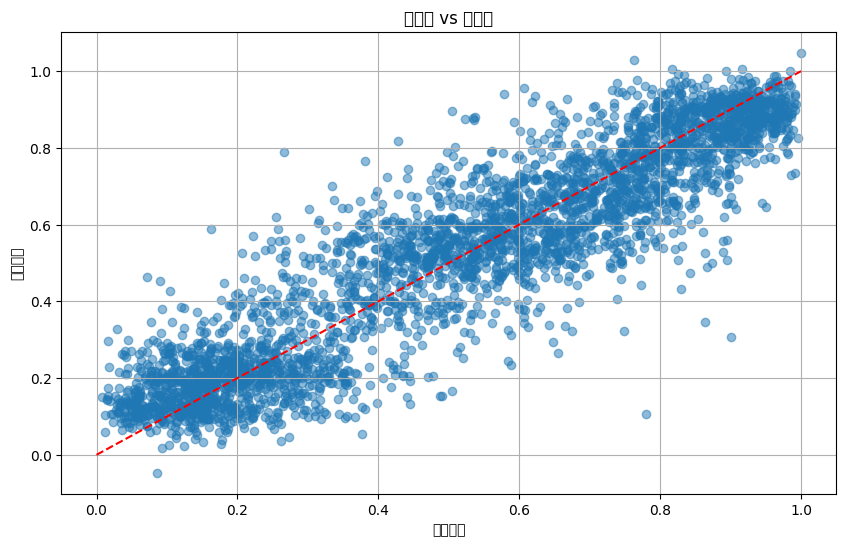

In [54]:
# 6. 可视化预测结果与真实标签的对比
plt.figure(figsize=(10, 6))

# 散点图：预测值 vs 真实值
plt.scatter(true_labels, predictions, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # 理想情况下的对角线

plt.xlabel('真实标签')
plt.ylabel('预测标签')
plt.title('预测值 vs 真实值')
plt.grid(True)
plt.savefig('prediction_vs_true.png')
plt.show()

/tmp/ipykernel_1194252/759105230.py:9: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.savefig('error_distribution.png')
/tmp/ipykernel_1194252/759105230.py:9: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig('error_distribution.png')
/tmp/ipykernel_1194252/759105230.py:9: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.savefig('error_distribution.png')
/tmp/ipykernel_1194252/759105230.py:9: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.savefig('error_distribution.png')
/tmp/ipykernel_1194252/759105230.py:9: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  plt.savefig('error_distribution.png')
/tmp/ipykernel_1194252/759105230.py:9: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  plt.savefig('error_distribution.png')
/tmp/ipykernel_1

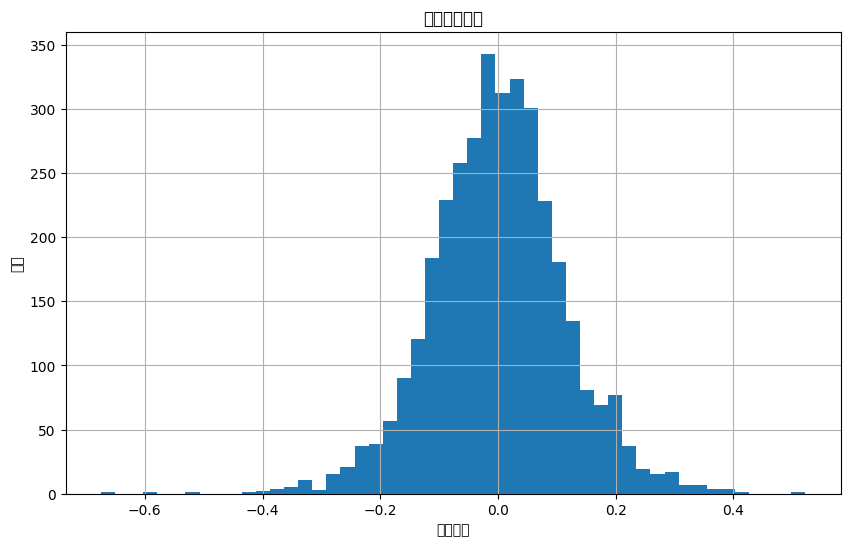

In [55]:
# 7. 误差分析
errors = predictions - true_labels
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.xlabel('预测误差')
plt.ylabel('频率')
plt.title('预测误差分布')
plt.grid(True)
plt.savefig('error_distribution.png')
plt.show()

In [56]:
# 8. 输出详细的预测结果（可选）
# 创建一个包含文本、真实标签和预测标签的DataFrame
results_df = pd.DataFrame({
    'text': test_dataset["text"],
    'true_label': true_labels,
    'predicted_label': predictions,
    'error': errors,
    'labels': test_dataset["label"]
})
results_df

,text,true_label,predicted_label,error,labels
0,冬奥8K转播背后的广东力量\n由广东科技企业研制的首款国产8K 50P小型化广播级摄像机参与...,0.290114,0.347717,0.057603,科学
1,"共模线圈线圈中的自感电动势总是与线圈中的电流变化抗.共模线圈对交流电流有阻碍作用,阻碍作用的...",0.446291,0.402474,-0.043817,科学
2,中华人民共和国交通运输部令2018年第37号《交通运输部关于修改〈民用航空器驾驶员合格审定规...,0.907974,0.941027,0.033053,政务
3,"""脱贫攻坚本来就是一场硬仗,而深度贫困地区脱贫攻坚是这场硬仗中的硬仗.我们务必深刻认识深度贫...",0.911156,0.718138,-0.193018,时政
4,"随着高新技术在军事上的广泛应用,使战争更具突发性,战争环境更加恶劣.在现代战争的人一机一环境...",0.470596,0.509313,0.038716,科学
...,...,...,...,...,...
3514,3月31日，国家主席习近平在华盛顿会议中心会见美国总统奥巴马。新华社记者谢环驰摄当地时间3月...,0.900696,0.904754,0.004058,政务
3515,"本文意译""Making Economic Sense""书中的""Eisnerizing Man...",0.158369,0.101650,-0.056719,娱乐
3516,"编剧陈彤:""平凡之路""写给涉世未深的年轻人\n中青报·中青网记者 沈杰群\n ""给我创作带...",0.780203,0.105552,-0.674651,法律
3517,"从2022年初教育部工作要点明确提出""实施教育数字化战略行动"",到三月教育部发布国家智慧教育...",0.524766,0.473018,-0.051748,教育


In [57]:

# 按误差绝对值排序，查看最大误差的样本
results_df['abs_error'] = np.abs(errors)
sorted_results = results_df.sort_values('abs_error', ascending=False)

print("\n预测误差最大的10个样本:")
for i, row in sorted_results.head(10).iterrows():
    print(f"文本: {row['text'][:100]}...")
    print(f"真实标签: {row['true_label']:.4f}, 预测标签: {row['predicted_label']:.4f},原本分类: {row['labels']}")
    print(f"误差: {row['error']:.4f}\n")


预测误差最大的10个样本:
文本: 编剧陈彤:"平凡之路"写给涉世未深的年轻人
中青报·中青网记者 沈杰群
  "给我创作带来灵感的是生活."作家,编剧陈彤接受中青报·中青网记者采访时说.
  为了笔下所写的剧情不"悬浮",在创作"平凡...
真实标签: 0.7802, 预测标签: 0.1056,原本分类: 法律
误差: -0.6747

文本: 中国广播电视音像资料馆,即中国中央电视台广播电视音像资料馆,是中央电视台的直属部门,是中央电视台内容资产的归口管理部门,是支持我台节目制播,满足节目制作需求,实现节目资料资源共享的管理平台,是服务社会...
真实标签: 0.9012, 预测标签: 0.3071,原本分类: 新闻
误差: -0.5940

文本: 建设一个天蓝,地绿,水清的美丽家园,是亿万人民的共同心愿.
党的十八大以来,习近平总书记着眼实现中华民族永续发展的根本大计,大力推进生态文明建设,推进生态文明体制改革.习近平总书记亲自谋划,亲自部署,...
真实标签: 0.2664, 预测标签: 0.7888,原本分类: 时政
误差: 0.5224

文本: [readpay]3[/readpay]
...
真实标签: 0.8642, 预测标签: 0.3464,原本分类: 政府工作报告
误差: -0.5178

文本: 去年汤加水下洪加火山喷发的延迟效应导致南极洲上空的臭氧空洞比往常提前了几周开放.
由于1987年"蒙特利尔议定书"逐步淘汰了氯氟烃等破坏臭氧的化学物质,臭氧层的空洞 -  - 平流层中保护地球免受太阳...
真实标签: 0.7493, 预测标签: 0.3225,原本分类: 电力
误差: -0.4268

文本: 近日,"唯实杯"第十届全国大学生机械创新设计大赛决赛在深圳技术大学举行.在本次大赛中,温州大学学子分别斩获国家级一等奖2项,三等奖3项,在全国704所参赛高校中名列前茅.
全国大学生机械创新设计大赛是...
真实标签: 0.1620, 预测标签: 0.5884,原本分类: 科学
误差: 0.4264

文本: 书前前后后加上做笔记一共读了三遍,第一遍只读了大概内容,对于书里的概念,逻辑,挂点没有完全掌握,第二遍理清了书的逻辑以及基本概念,第三遍才算彻底的了解作者所要讲的内容.
全书以产品为中心展开叙述,在企...
真实标签: 0.8299

In [58]:
sorted_results

,text,true_label,predicted_label,error,labels,abs_error
3516,"编剧陈彤:""平凡之路""写给涉世未深的年轻人\n中青报·中青网记者 沈杰群\n ""给我创作带...",0.780203,0.105552,-0.674651,法律,0.674651
2343,"中国广播电视音像资料馆,即中国中央电视台广播电视音像资料馆,是中央电视台的直属部门,是中央电...",0.901158,0.307143,-0.594015,新闻,0.594015
2500,"建设一个天蓝,地绿,水清的美丽家园,是亿万人民的共同心愿.\n党的十八大以来,习近平总书记着...",0.266367,0.788799,0.522432,时政,0.522432
369,[readpay]3[/readpay]\n,0.864161,0.346371,-0.517790,政府工作报告,0.517790
3474,去年汤加水下洪加火山喷发的延迟效应导致南极洲上空的臭氧空洞比往常提前了几周开放.\n由于19...,0.749291,0.322478,-0.426812,电力,0.426812
...,...,...,...,...,...,...
3091,"摘要:第一条为了加强城市生活垃圾分类管理,推进生活垃圾减量化、资源化、无害化,改善人居环境,...",0.784154,0.783957,-0.000198,法律1,0.000198
2719,【何关根】何关根，籍贯上海浦东，何英杰家族成员。香港烟草有限公司创办人何英杰长子，与妻子金梅...,0.206165,0.206041,-0.000124,其它,0.000124
384,"BIM技术是一种应用于工程设计建造管理的数据化工具,通过参数模型整合各种项目的相关信息,在项...",0.568383,0.568497,0.000114,房地产,0.000114
1564,学习路上按：中共十八大以来，以习近平为总书记的新一届中央领导集体，带领全党全国各族人民积极应...,0.974273,0.974190,-0.000084,政务,0.000084



不同标签区间的MSE:
0-0.2: 0.0092
0.2-0.4: 0.0168
0.4-0.6: 0.0141
0.6-0.8: 0.0139
0.8-1.0: 0.0106


/tmp/ipykernel_1194252/2696104827.py:23: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from current font.
  plt.savefig('mse_by_label_bin.png')
/tmp/ipykernel_1194252/2696104827.py:23: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  plt.savefig('mse_by_label_bin.png')
/tmp/ipykernel_1194252/2696104827.py:23: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.savefig('mse_by_label_bin.png')
/tmp/ipykernel_1194252/2696104827.py:23: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.
  plt.savefig('mse_by_label_bin.png')
/tmp/ipykernel_1194252/2696104827.py:23: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  plt.savefig('mse_by_label_bin.png')
/tmp/ipykernel_1194252/2696104827.py:23: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.savefig('mse_by_label_bin.png')
/tmp/ipykernel_1

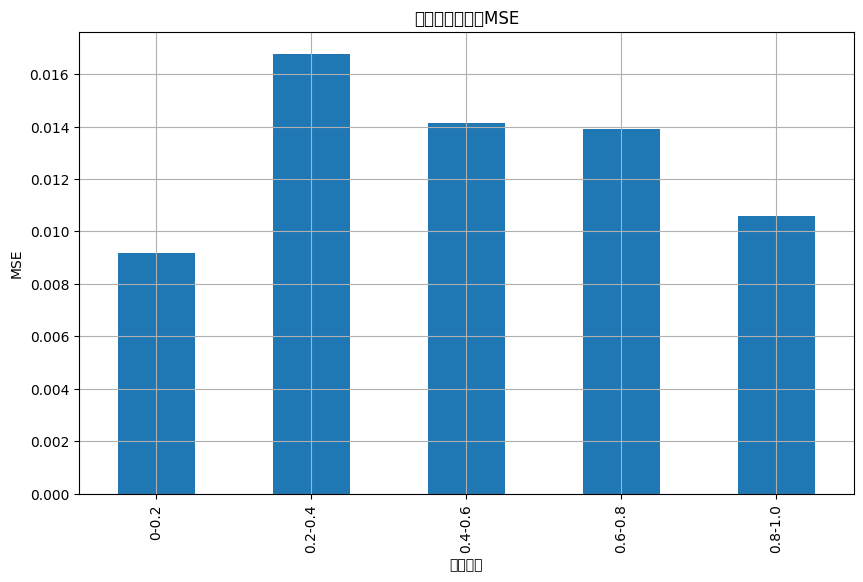

In [59]:
# 10. 分析不同标签区间的性能（可选）
# 将标签分成几个区间，查看模型在不同区间的表现
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
results_df['label_bin'] = pd.cut(results_df['true_label'], bins=bins, labels=bin_labels)

# 计算每个区间的MSE
bin_mse = results_df.groupby('label_bin').apply(
    lambda x: mean_squared_error(x['true_label'], x['predicted_label'])
)

print("\n不同标签区间的MSE:")
for bin_name, mse_value in bin_mse.items():
    print(f"{bin_name}: {mse_value:.4f}")

# 可视化不同区间的MSE
plt.figure(figsize=(10, 6))
bin_mse.plot(kind='bar')
plt.xlabel('标签区间')
plt.ylabel('MSE')
plt.title('不同标签区间的MSE')
plt.grid(True)
plt.savefig('mse_by_label_bin.png')
plt.show()